In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
from tqdm import tqdm

import importlib
importlib.reload(lime.lime_tabular_mod)
repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load dataset: Mushrooms

In [2]:
dataset = repo.get_mushrooms_dataset()
dataset.train_data

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_brown,cap-color_buff,cap-color_cinnamon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,cap-color_yellow,bruises_bruises,bruises_no,odor_almond,odor_anise,odor_creosote,odor_fishy,odor_foul,odor_musty,odor_none,odor_pungent,odor_spicy,gill-attachment_attached,gill-attachment_free,gill-spacing_close,gill-spacing_crowded,gill-size_broad,gill-size_narrow,gill-color_black,gill-color_brown,gill-color_buff,gill-color_chocolate,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,gill-color_yellow,stalk-shape_enlarging,stalk-shape_tapering,stalk-root_bulbous,stalk-root_club,stalk-root_equal,stalk-root_rooted,stalk-root_unknown,stalk-surface-above-ring_fibrous,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_fibrous,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,stalk-color-above-ring_brown,stalk-color-above-ring_buff,stalk-color-above-ring_cinnamon,stalk-color-above-ring_gray,stalk-color-above-ring_orange,stalk-color-above-ring_pink,stalk-color-above-ring_red,stalk-color-above-ring_white,stalk-color-above-ring_yellow,stalk-color-below-ring_brown,stalk-color-below-ring_buff,stalk-color-below-ring_cinnamon,stalk-color-below-ring_gray,stalk-color-below-ring_orange,stalk-color-below-ring_pink,stalk-color-below-ring_red,stalk-color-below-ring_white,stalk-color-below-ring_yellow,veil-type_partial,veil-color_brown,veil-color_orange,veil-color_white,veil-color_yellow,ring-number_none,ring-number_one,ring-number_two,ring-type_evanescent,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_black,spore-print-color_brown,spore-print-color_buff,spore-print-color_chocolate,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,spore-print-color_yellow,population_abundant,population_clustered,population_numerous,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
1658,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4649,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
4770,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
157,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5192,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Check performance of different classifiers on selected dataset (with their default settings)

In [3]:
models = [
    ("Random Forest", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("DecisionTree", sklearn.tree.DecisionTreeClassifier()),
    ("Neural Network", sklearn.neural_network.MLPClassifier()),
    ("SVM", sklearn.svm.LinearSVC()),
    ("Naive Bayes", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = dataset.train_data.to_numpy()
    y = dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = dataset.test_data.to_numpy()
    y_true = dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")

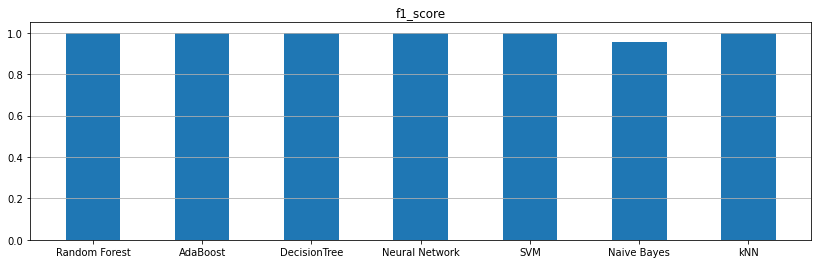

In [4]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()

## Use LIME to explain prediction
### Create explainer object
At first create explainer object that makes use of training data.
It may be used by discretizer inner object and enhance local surrogate's performance.

In [5]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    dataset.train_data.to_numpy(),
    feature_names = dataset.train_data.columns.to_list(),
    class_names = dataset.train_labels.drop_duplicates().to_list(), # should be equal to model.classes_
    discretize_continuous=False,
    sample_around_instance=True,
    categorical_features=dataset.categorical_features
)

In [6]:
test_data_subset = dataset.test_data.to_numpy()

labels_count = 2
bins_count = 50
test_instances_count = test_data_subset.shape[0]

scores_for_surrogate_model = np.empty(shape=(test_instances_count, labels_count), dtype="float32")
losses_for_surrogate_model = np.empty(shape=(test_instances_count, labels_count), dtype="float32")
fidelity_loss_on_explanation = np.empty(shape=(test_instances_count,), dtype="float32")
fidelity_loss_on_generated_data = np.empty(shape=(test_instances_count,), dtype="float32")
fidelity_loss_distribution_quantiles = np.empty(shape=(test_instances_count, bins_count), dtype="float32")

for idx, test_instance in enumerate(tqdm(test_data_subset)):
    explanation = explainer.explain_instance(
        test_instance.reshape(-1),
        model.predict_proba,
        num_features = 4,
        top_labels = labels_count,
        distance_metric="minkowski",
        minkowski_norm=100.
    )
    scores_for_surrogate_model[idx, :] = explanation.get_scores_for_surrogate_model()
    losses_for_surrogate_model[idx, :] = explanation.get_losses_for_surrogate_model()
    fidelity_loss_on_explanation[idx] = explanation.get_fidelity_loss_on_explanation()
    fidelity_loss_on_generated_data[idx] = explanation.get_fidelity_loss_on_generated_data()
    fidelity_loss_distribution_quantiles[idx, :] = explanation.get_fidelity_loss_distribution(bins=bins_count)

100%|██████████| 1625/1625 [2:55:58<00:00,  6.50s/it]  


label #0 mean score: 0.18030855059623718
label #1 mean score: 0.18030855059623718


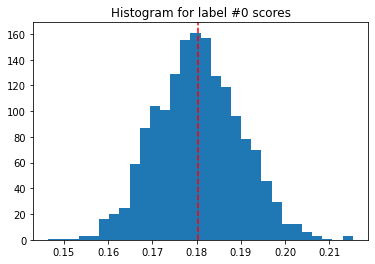

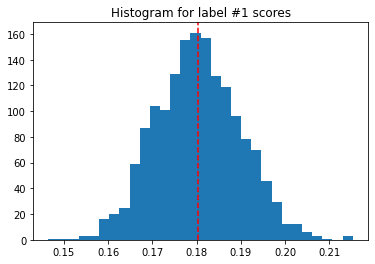

In [7]:
for idx in range(labels_count):
    mean_score = np.mean(scores_for_surrogate_model[:, idx])
    print(f"label #{idx} mean score: {mean_score}", flush=True)
    plt.hist(scores_for_surrogate_model[:, idx], bins=30)
    plt.axvline(mean_score, color="red", linestyle="--")
    plt.title(f"Histogram for label #{idx} scores")
    plt.show()

label #0 mean loss: 0.16446225345134735
label #1 mean loss: 0.16446225345134735


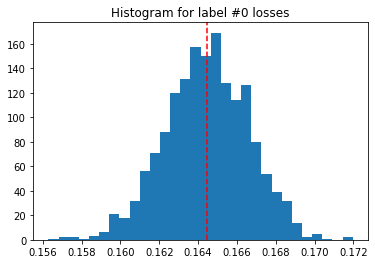

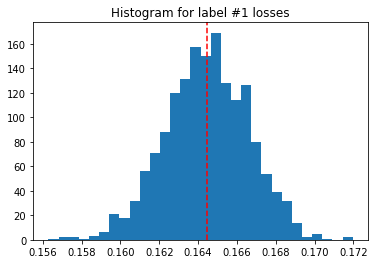

In [8]:
for idx in range(labels_count):
    mean_loss = np.mean(losses_for_surrogate_model[:, idx])
    print(f"label #{idx} mean loss: {mean_loss}")
    plt.hist(losses_for_surrogate_model[:, idx], bins=30)
    plt.axvline(mean_loss, color="red", linestyle="--")
    plt.title(f"Histogram for label #{idx} losses")
    plt.show()

Mean fidelity loss on explanation: 0.15161845088005066


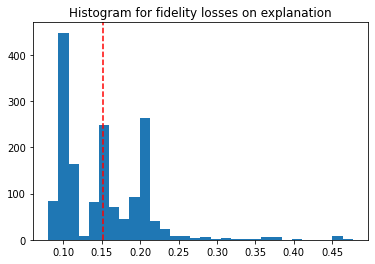

In [9]:
mean_fidelity_loss_on_explanation = np.mean(fidelity_loss_on_explanation)
print(f"Mean fidelity loss on explanation: {mean_fidelity_loss_on_explanation}")
plt.hist(fidelity_loss_on_explanation, bins=30)
plt.axvline(mean_fidelity_loss_on_explanation, color="red", linestyle="--")
plt.title(f"Histogram for fidelity losses on explanation")
plt.show()

Mean fidelity loss on generated data: 0.17509180307388306


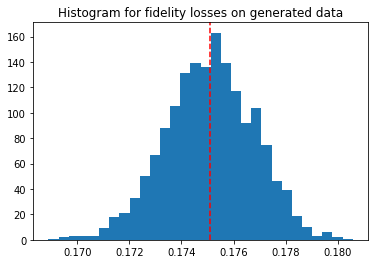

In [10]:
mean_fidelity_loss_on_generated_data = np.mean(fidelity_loss_on_generated_data)
print(f"Mean fidelity loss on generated data: {mean_fidelity_loss_on_generated_data}")
plt.hist(fidelity_loss_on_generated_data, bins=30)
plt.axvline(mean_fidelity_loss_on_generated_data, color="red", linestyle="--")
plt.title(f"Histogram for fidelity losses on generated data")
plt.show()

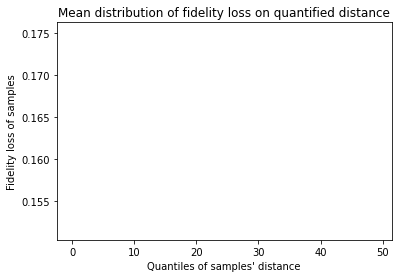

In [11]:
plt.plot(np.mean(fidelity_loss_distribution_quantiles, axis=0))
plt.ylabel(f"Fidelity loss of samples")
plt.xlabel(f"Quantiles of samples' distance")
plt.title(f"Mean distribution of fidelity loss on quantified distance")
plt.show()